# **Producción convencional y no convencional de petróleo y gas**

---



El presente archivo contiene el código utilizado para obtener, procesar y analizar los datos del precio de la producción convencional y no convencional de petróleo y gas, desde el 2006 hasta la fecha.

Las cantidades producidas de ambos hidrocarburos resultan de particular interés para medir el desarrollo del sector y sus posibilidades de expansión.

Como resultado del análisis de datos, se presentan tres figuras: dos gráficos de área, exhibiendo la producción convencional y no convencional de petróleo y gas, respectivamente, y un gráfico de líneas que exhibe el porcentaje de la producción no convencional sobre el total producido.


## Preliminar

### Importación de *libraries*

Se importan las *libraries* a utilizar en el código.

In [ ]:
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date
import plotly.graph_objects as go
import plotly.io as pio

### Exportación a archivo `.pdf`

En caso de precisarse exportar las figuras resultantes a formato `.pdf`, se debe instalar el *package* `kaleido`.

**IMPORTANTE**: para evitar problemas de desconexión, es recomendable ejecutar el código la siguiente celda y, una vez terminado el proceso de instalación, reiniciar el entorno de ejecución y ejecutar todas las celdas.

In [ ]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Producción de petróleo y gas

### Obtención de datos

Los datos de la producción de petróleo y gas son publicados mensualmente por la Secretaría de Energía en el portal de Datos Abiertos del Gobierno Nacional.

La publicación se conoce como "Producción de petróleo y gas por pozo (Capítulo IV)" y consiste en el "detalle mensual de producción por pozo, yacimiento, concesión y provincia".

Incluye datos de la producción de petróleo (m<sup>3</sup>), gas (miles de m<sup>3</sup>) y agua (m<sup>3</sup>).

La documentación de este *dataset* puede encontrarse en: https://github.com/datosminem/produccion-de-petroleo-y-gas-por-pozo

El link `url_dataset` refiere a dicho documento.

In [ ]:
url_dataset = "http://datos.energia.gob.ar/dataset/produccion-de-petroleo-y-gas-por-pozo"

El *dataset* contiene una variedad de archivos.

Se pretende extraer solo aquellos links que contienen el `identifier` a continuación.

In [ ]:
identifier = "produccin-de-pozos-de-gas-y-petrleo"

Se define la función `href_extractor` para obtener todos los links deseados a partir del *dataset*.

Esta función tiene dos parámetros:

*   `url`: link del cual extraer los datos de la lista
*   `list_of_links`: lista vacía donde almacenar los datos extraídos.

Primeramente, la función obtiene y abre la `url` especificada. Luego, con la *library* `BeautifulSoup`, se crea un objeto HTML para analizar. Iterando sobre todos los links encontrados en este objeto HTML (`.findAll('a')`), se adjunta a la lista `list_of_links` solo aquellos que son archivos `.csv` y, además, contienen el `identifier` antes especificado.

In [ ]:
def href_extractor(url, list_of_links):
  req = Request(url)
  page = urlopen(req)
  html_parser = BeautifulSoup(page, "lxml")
  for link in html_parser.findAll('a'):
    if str(link.get('href')).endswith('.csv'):
      if identifier in str(link.get('href')):
            list_of_links.append(link.get('href'))
      else: pass
    else: pass

Se ejecuta la función `href_extractor` para la url del *dataset* y se seleccionan los links deseados.

La lista `enlisted_links` contiene los links de los archivos `.csv` a analizar.

In [ ]:
enlisted_links = []

In [ ]:
href_extractor(url_dataset, enlisted_links)

In [ ]:
enlisted_links = enlisted_links[1:-18]

Una vez obtenidos dichos links, se itera sobre ellos para leer los archivos `.csv` (con el comando `pd.read_csv`).

Por motivos de eficiencia, mediante el comando `usecols`, se especifican las columnas a leer de cada archivo `.csv`, lo que evita la lectura innecesaria de columnas. Las columnas de interés se encuentran en la lista `cols`.

A su vez, solo se analizan los datos cuyo `tipo_de_recurso` es "CONVENCIONAL" o "NO CONVENCIONAL".

Todos los *dataframes* son anexados en un único `DataFrame` completo (`df`).

In [ ]:
cols = ['anio', 'mes', 'prod_pet', 'prod_gas', 'tipo_de_recurso']

In [ ]:
tipos_de_recursos = ['CONVENCIONAL', 'NO CONVENCIONAL']

In [ ]:
produccion = pd.DataFrame()
for link in enlisted_links:
  each_frame = pd.read_csv(link, usecols=cols)
  each_frame = each_frame[each_frame['tipo_de_recurso'].isin(tipos_de_recursos)].reset_index(drop=True)
  produccion = produccion.append(each_frame, ignore_index=True)

<ipython-input-56-095cda51a412>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-56-095cda51a412>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-56-095cda51a412>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-56-095cda51a412>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-56-095cda51a412>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-56-095cda51a412>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

### *Data Cleaning*

El *DataFrame* contiene información desde enero del año 2006 hasta la fecha, para cada pozo registrado. Sin embargo, esta medición "desagregada" resulta engorrosa para su análisis.

Mediante el comando `.groupby()` se agrupa dicho *DataFrame* según el año, mes y tipo de recurso. Los valores de las columnas `prod_pet` y `prod_gas` refieren a la suma de la producción, para cada año, mes y tipo de recurso.

In [ ]:
produccion = produccion.groupby(by=["anio", "mes", "tipo_de_recurso"], as_index=False)[["prod_pet", "prod_gas"]].sum()

El *DataFrame* `produccion` tiene, ahora, 2 filas por cada conjunto año-mes (una por cada tipo de recurso). Para transformar esta tabla, se utiliza `.pivot()` de forma tal de convertir cada par de filas en una única fila con 2 columnas (nuevamente, una por cada tipo de recurso).

In [ ]:
produccion = produccion.pivot(index=["anio", "mes"], columns='tipo_de_recurso', values=["prod_pet", "prod_gas"]).reset_index()

Aplicar `pivot()` implica la creación de un `MultiIndex` en las columnas del *DataFrame*. Este índice puede *aplanarse* para mayor comodidad.

In [ ]:
produccion.columns = [''.join(map(str, column)) for column in produccion.columns]

Se renombran las columnas.

In [ ]:
produccion = produccion.rename(columns = {
    produccion.columns[2]: "Petróleo - Convencional",
    produccion.columns[3]: "Petróleo - No convencional",
    produccion.columns[4]: "Gas - Convencional",
    produccion.columns[5]: "Gas - No convencional"
})

La columna "Período" puede servir como un índice temporal, de la siguiente manera:

1.   Las columnas "anio" y "mes" deben ser interpretadas como cadenas de texto: `.astype(str)`.
2.   La columna "Período" surge de la transformación en `datetime` (`pd.to_datetime`) de una cadena de texto conformada por: "anio" + "mes" + "1", donde "1" es el día. Se aplica el formato correspondiente.

In [ ]:
produccion['anio'] = produccion['anio'].astype(str)
produccion['mes'] = produccion['mes'].astype(str)
produccion['Período'] = pd.to_datetime(produccion['anio']+produccion['mes']+"1", format="%Y%m%d")

Por conveniencia, se cambia el orden de las columnas del *DataFrame*, poniendo a la columna "Período" como primera columna.

In [ ]:
produccion.insert(0, "Período", produccion.pop("Período"))

A partir de los valores de la columna "Período", se crea una nueva columna ("Días") que indica la cantidad de días de cada mes.

In [ ]:
produccion['Días'] = produccion['Período'].dt.daysinmonth

Los valores de producción de petróleo y gas (convencional y no convencional) representan los valores totales de producción mensual.

Para obtener el promedio diario de cada uno de dichos valores, se divide cada valor por la cantidad de días del mes.

Asimismo, se efectúa un cambio de medidas: 
or otra parte,  y la de 

*   la producción de gas se encuentra en miles de m<sup>3</sup> diarios, pero debe expresarse en millones de m<sup>3</sup> diarios. A tal fin, se la divide por 1000.
*   la producción de petróleo se encuentra en m<sup>3</sup> diarios, pero debe expresarse en miles de barriles diarios. A tal fin, se la divide por el `conversor_m3_bbl`.

In [ ]:
for column in produccion.columns[3:-1]:
  if "Gas" in column:
    produccion[column+" (diarios)"] = produccion[column]/produccion['Días']/1000
  else:
    produccion[column+" (diarios)"] = produccion[column]/produccion['Días']/158.987

### *DataFrame final*



Se eliminan las columnas innecesarias y se reordena el *DataFrame*.

In [ ]:
produccion = produccion.loc[:,[produccion.columns[0]] + produccion.columns[8:].tolist()]

El armado del *DataFrame* final (`produccion`) contiene los datos de producción de petróleo y gas convencional y no convencional, expresados en promedios diarios y en las unidades deseadas (millones de m<sup>3</sup> en el caso del gas, y miles de barriles en el caso del petróleo).

A continuación, se presentan las primeras 5 filas de dicho *DataFrame*.

In [ ]:
produccion.head()

,Período,Petróleo - Convencional (diarios),Petróleo - No convencional (diarios),Gas - Convencional (diarios),Gas - No convencional (diarios)
0,2006-01-01,612.463689,0.217102,135.378458,1.048646
1,2006-02-01,618.959207,0.223403,138.662466,1.099746
2,2006-03-01,646.638602,0.230661,137.409990,1.065889
3,2006-04-01,649.043297,0.233495,138.909811,1.045404
4,2006-05-01,658.685629,0.305404,142.420135,1.265120


Por último, se exporta el *DataFrame* en formato `.xlsx`.

In [ ]:
produccion.to_excel("Producción convencional y no convencional de gas y petróleo.xlsx", index=False)

## Figuras

### General

Las variables `today_year` y `today_month` contienen los valores del año y el mes, respectivamente, en el que se ejecuta el código.

In [ ]:
today_year = date.today().year
today_month = date.today().month

Para hacer más eficiente el código, se crean dos funciones que servirán para crear las figuras y modificar sus atributos esenciales.

La primera función (`stacked_area_plot`) genera un gráfico de áreas apilada.

Los parámetros de esta función son:

*   `fig`: el nombre de la figura a utilizar.
*   `columns`: lista que agrupa las columnas del *DataFrame* que se graficarán.
*   `fill_order`: lista que agrupa el órden en el que las líneas serán graficadas. En particular, se requiere que una de las líneas sirva de "base", mientras que la/s otra/s se apilen sobre ella.
*   `names_order`: lista que agrupa el orden de aparición de las etiquetas.
*   `aggregate`: lista que agrupa una variable dicotómica, cuyo valor es `0` si la columna refiere a un hidrocarburo convencional, y, en caso contrario, es el valor de ese mismo hidrocarburo convencional.

In [ ]:
def stacked_area_plot(fig, columns, colors, aggregate):
  for column, color, fill, name, agg in zip(columns, colors, ["tozeroy", "tonexty"], ["Convencional", "No convencional"], aggregate):
    fig.add_trace(
      go.Scatter(
        showlegend = True,
        name = name,
        mode = "lines",
        x = produccion["Período"],
        y = produccion[column],
        line = dict(color = color),
        fill = fill,
        stackgroup = 'one'
      )
      )
    fig.add_trace(
      go.Scatter(
        showlegend = False,
        name = name + " - EoP",
        mode = "markers",
        x = produccion["Período"].tail(1),
        y = produccion[column].tail(1) + agg,
        marker = dict(color = color, size=10),
      )
      )
    fig.add_annotation(
      x = produccion["Período"][len(produccion)-1],
      y = produccion[column][-1:].values[0] + agg,
      text = round(produccion[column][-1:].values[0], 1).astype(str),
      font = dict(color = color),
      xanchor = "left",
      xshift = 5,
      yshift = 0,
      showarrow = False
      )

La segunda función, `update_layout_fig` contiene el código para modificar el aspecto de la figura en general.

Sus parámetros son:


*   `fig`: el nombre de la figura a utilizar.
*   `max`: valor máximo del eje de ordenadas.
*   `title_text`: título del eje de ordenadas.


In [ ]:
def prod_update_layout(fig, max, title_text):
  fig.update_layout(
    plot_bgcolor = 'rgba(0,0,0,0)',
    margin = dict(
        b=15,
        t=15,
        l=15,
        r=50
    ),
    legend = dict(
        title = None,
        orientation = 'h',
        xanchor = 'center', 
        x = 0.5, 
        yanchor = 'bottom', 
        y = 1,
        font = dict(
            size = 16
            )
        ),
    height = 750,
    width = 1000,
    xaxis = dict(
        range = [produccion["Período"][0], dt.date(today_year,today_month,15)],
        title = None,
        tickformat = "%m\n<b>%Y",
        dtick = "M6",
        tickangle = 0
        ),
    yaxis = dict(
        range = [-2, max],
        title = dict(
            text=title_text
            ),
        showgrid=True,
        gridcolor='lightgray'
        ),
    font = dict(
        size = 14,
        family = "serif"
        )
    )

### Figura: Producción convencional y no convencional de gas

La escala de colores elegida para el gas es la siguiente escala binaria.

In [ ]:
colors_gas = ["#72B7B2", "#E45756"]

En tanto, la variable dicotómica `aggregate_gas` es:


*   0 si la columna es "Gas - Convencional (diarios)"
*   El valor de "Gas - Convencional (diarios)" si la columna es "Gas - No convencional (diarios)"



In [ ]:
aggregate_gas = [0, produccion[produccion.columns[3]][len(produccion)-1]]

Se crea la figura `prod_gas` en el entorno de Plotly (utilizando `graph_objects` como `go`).

In [ ]:
prod_gas = go.Figure()

Dicha figura es actualizada a partir de las funciones `stacked_area_plot` y `prod_update_layout`, con los parámetros antes especificados.

Nótese que `produccion.columns[3:5].tolist()` construye una lista a partir de las columnas correspondientes al gas.

In [ ]:
stacked_area_plot(prod_gas, produccion.columns[3:5].tolist(), colors_gas, aggregate_gas)

prod_update_layout(prod_gas, 160, "<b>MM de m\u00b3 / día")

A continuación, se exhibe la figura.

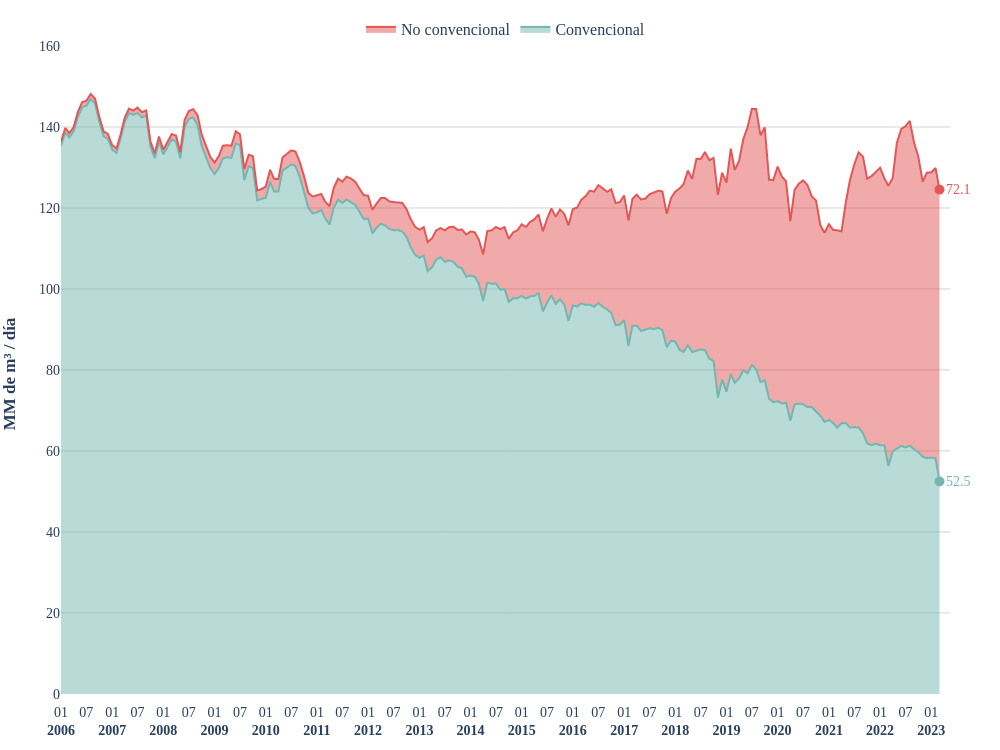

In [ ]:
prod_gas.show("png")

Si se desea exportar la figura a formato `.pdf`, se debe des-comentar y ejecutar la siguiente celda. Recuérdese que el *package* `kaleido` debe estar correctamente instalado.

In [ ]:
pio.write_image(prod_gas, "Figura Produccion Gas.pdf", width=3*300, height=2.25*300)

### Figura: Producción convencional y no convencional de petróleo

La escala de colores elegida para el petróleo es la siguiente escala binaria.

In [ ]:
colors_petroleo = ["#FF9DA6", "#54A24B"]

En tanto, la variable dicotómica `aggregate_pet` es:


*   0 si la columna es "Petróleo - Convencional (diarios)"
*   El valor de "Petróleo - Convencional (diarios)" si la columna es "Petróleo - No convencional (diarios)"



In [ ]:
aggregate_pet = [0, produccion[produccion.columns[1]][len(produccion)-1]]

Se crea la figura `prod_pet` en el entorno de Plotly (utilizando `graph_objects` como `go`).

In [ ]:
prod_pet = go.Figure()

Dicha figura es actualizada a partir de las funciones `stacked_area_plot` y `prod_update_layout`, con los parámetros antes especificados.

Nótese que `produccion.columns[3:5].tolist()` construye una lista a partir de las columnas correspondientes al gas.

In [ ]:
stacked_area_plot(prod_pet, produccion.columns[1:3].tolist(), colors_petroleo, aggregate_pet)

prod_update_layout(prod_pet, 700, "<b>Miles de barriles / día")

A continuación, se exhibe la figura.

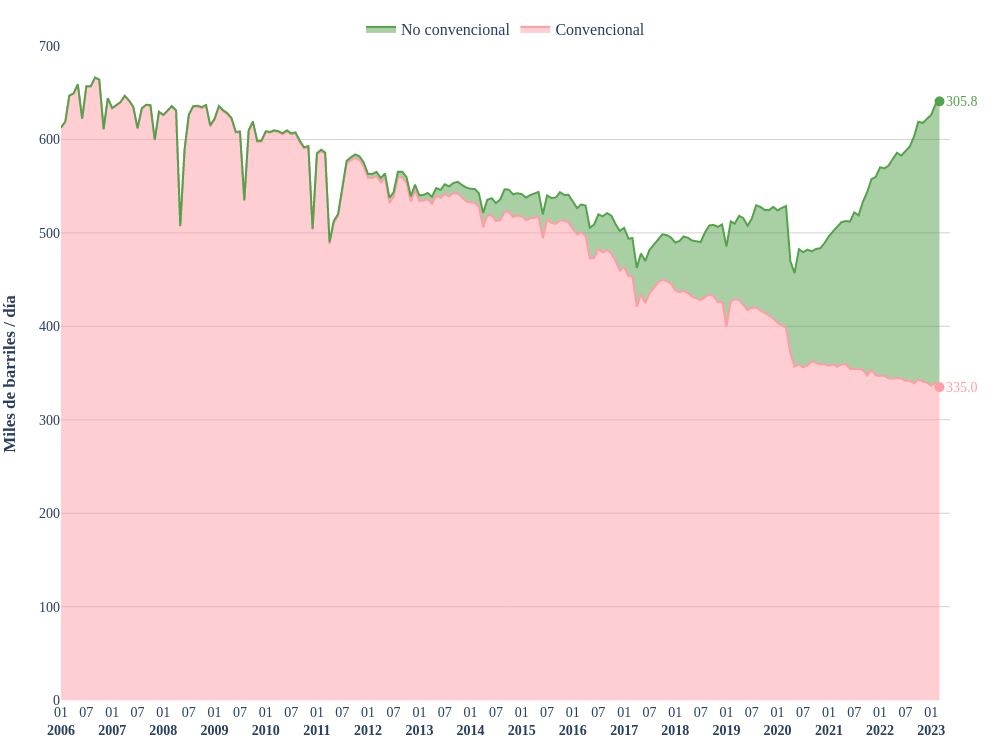

In [ ]:
prod_pet.show("png")

Si se desea exportar la figura a formato `.pdf`, se debe des-comentar y ejecutar la siguiente celda. Recuérdese que el *package* `kaleido` debe estar correctamente instalado.

In [ ]:
pio.write_image(prod_pet, "Figura Produccion Petroleo.pdf", width=3*300, height=2.25*300)

### Figura: Porcentaje de producción no convencional sobre total

Para la creación de esta figura es necesario agregar 2 columnas más al *DataFrame*, con el único objetivo de facilitar los cálculos. Los valores de estas columnas corresponden al porcentaje de producción no convencional sobre el total.

In [ ]:
for i in range(2, len(produccion.columns), 2):
  produccion[produccion.columns[i] + " % s/t"] = produccion[produccion.columns[i]] / (produccion[produccion.columns[i]] + produccion[produccion.columns[i-1]]) * 100

La escala de colores elegida para esta figura es, también, binaria.

In [ ]:
colors_perc = [colors_petroleo[1], colors_gas[1]]

Se crea la figura `perc_NC` en el entorno de Plotly (utilizando `graph_objects` como `go`).

In [ ]:
perc_NC = go.Figure()

Al tratarse de una sola figura, en este caso, no se define una función, sino que las especificaciones de la figura se encuentran en el argumento de ésta. Sin embargo, sí se utiliza la función `prod_update_layout` para modificar el aspecto de la figura en general.

In [ ]:
for column, color, producto in zip(produccion.columns[-2:], colors_perc, ["Petróleo - No convencional", "Gas - No convencional"]):
  perc_NC.add_trace(
    go.Scatter(
      x=produccion["Período"],
      y= produccion[column],
      mode='lines',
      line=dict(color = color, width=3),
      name = producto,
    ))
  perc_NC.add_trace(
    go.Scatter(
      showlegend=False,
      x=produccion["Período"].tail(1),
      y=produccion[column].tail(1),
      mode='markers',
      marker=dict(color=color, size=10)
    ))
  perc_NC.add_annotation(
    x=produccion["Período"][len(produccion)-1],
    y = produccion[column][len(produccion)-1],
    text=round(produccion[column][len(produccion)-1], 1).astype(str),
    font=dict(color=color, size=14),
    xanchor="left",
    xshift=5,
    yshift=0,
    showarrow=False
    )

prod_update_layout(perc_NC, 75, "<b>% del total")

A continuación, se exhibe la figura.

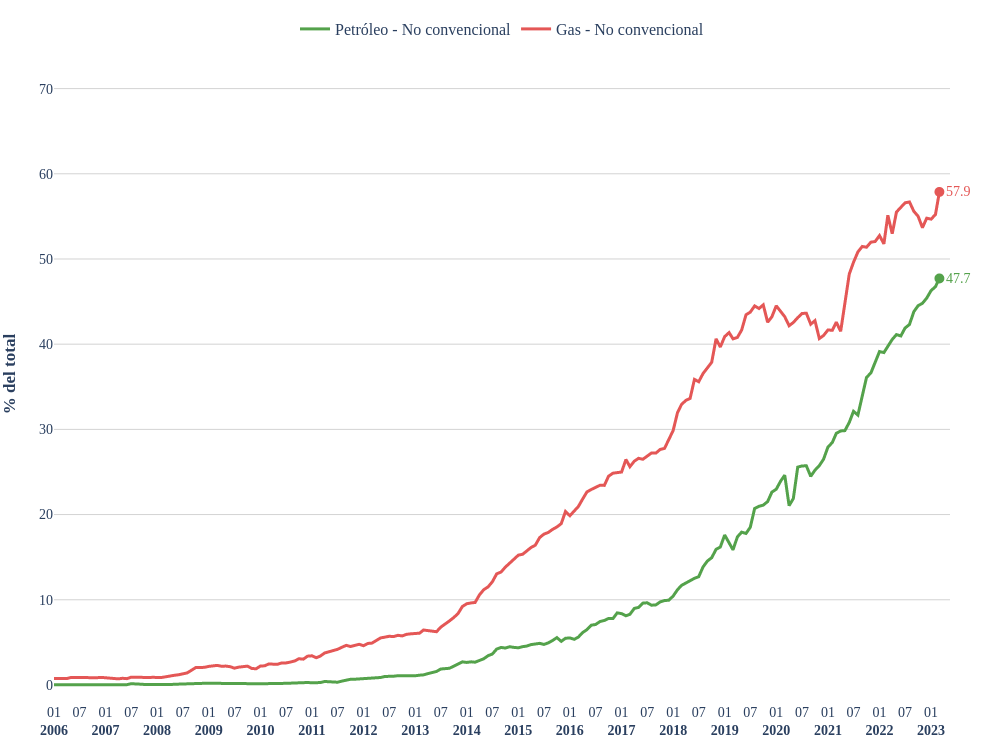

In [ ]:
perc_NC.show("png")

Si se desea exportar la figura a formato `.pdf`, se debe des-comentar y ejecutar la siguiente celda. Recuérdese que el *package* `kaleido` debe estar correctamente instalado.

In [ ]:
pio.write_image(perc_NC, "Figura Produccion NC.pdf", width=3*300, height=2.25*300)